# Drug response Correlation to Dynamic Features 

## Initialisation

In [73]:
import os

import numpy as np
import pandas as pd

path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find('project')
# slice the path from the index of 'project' to the end
project_path = path[:index_project+7]
# set the working directory
os.chdir(project_path)
print(f'Project path set to: {os.getcwd()}')

Project path set to: c:\Github\ode-biomarker-project


In [74]:
# Bring in CCLE data
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [75]:
# Import dynamic simulations
from PathLoader import PathLoader
from DataLink import DataLink
path_loader = PathLoader('data_config.env', 'current_user.env')
data_link = DataLink(path_loader, 'data_codes.csv')

In [76]:
# drug_db = 'gdsc-1'
# drug = 'Palbociclib'
# drug_code = f'{drug_db}-{drug}'
# dynamic_feature_code = 'cdk46_ccle_dynamic_features_v3'
# dynamic_feature_code_process = f'{dynamic_feature_code}-true-Unnamed: 0'
# match_rules_code = 'cdk_model_match_rules'
# use_active_form_only = False
# # Options
# folder_name = 'CDK46_dynamic_vs_drug_response'
# exp_id = 'Palbociclib_gdsc1'
# save_figure = True

In [77]:
# drug_db = 'gdsc-2'
# drug = 'Palbociclib'
# drug_code = f'{drug_db}-{drug}'
# dynamic_feature_code = 'cdk46_ccle_dynamic_features_v3'
# dynamic_feature_code_process = f'{dynamic_feature_code}-true-Unnamed: 0'
# match_rules_code = 'cdk_model_match_rules'
# use_active_form_only = False
# # Options
# folder_name = 'CDK46_dynamic_vs_drug_response'
# exp_id = 'Palbociclib_gdsc2'
# save_figure = True

In [78]:
drug_db = 'gdsc-1'
drug = 'FGFR_0939'
drug_code = f'{drug_db}-{drug}'
dynamic_feature_code = 'fgfr4_ccle_dynamic_features_v2'
dynamic_feature_code_process = f'{dynamic_feature_code}-true-Unnamed: 0'
match_rules_code = 'fgfr4_model_ccle_match_rules'
use_active_form_only = True
# Options
folder_name = 'FGFR4_dynamic_vs_drug_response'
exp_id = 'FGFR_0939_gdsc1'
save_figure = True

In [79]:
### Initialisation Data 
dynamic_feature = data_link.get_data_from_code(dynamic_feature_code)
ccle_data = data_link.get_data_from_code('ccle')

# load in original ccle data
loading_code = f'ccle-{drug_code}-LN_IC50-sin'
feature_data, label_data = data_link.get_data_using_code(loading_code)

match_rules_file = data_link.get_data_from_code(match_rules_code)
match_rules_files_dropna = match_rules_file.dropna(subset=['reference'])
match_rules_files_dropna_active_only = match_rules_files_dropna.loc[match_rules_files_dropna['is_active_form'] == True]

# load in original ccle data
loading_code = f'generic-{drug_code}-LN_IC50-{dynamic_feature_code_process}'
# generic-gdsc-{number}-{drug_name}-{target_label}-{dataset_name}-{replace_index}-{row_index}
dynamic_feature_data, dynamic_label_data = data_link.get_data_using_code(loading_code)

dynamic_feature_label = ['auc', 'median', 'tfc', 'tmax',
                 'max', 'tmin', 'min', 'ttsv', 'tsv']

In [80]:
print(dynamic_feature_data.shape)
print(feature_data.shape)

(665, 260)
(667, 19221)


In [81]:
# remove samples present in feature data but not in dynamic feature data
new_feature_data = feature_data.loc[feature_data.index.isin(dynamic_feature_data.index)]
new_label_data = label_data.loc[label_data.index.isin(dynamic_feature_data.index)]

# check size 
print(new_feature_data.shape)
print(new_label_data.shape)

(665, 19221)
(665,)


## Config

In [82]:
from scipy.stats import pearsonr

import matplotlib.pyplot as plt

import os

# ignore ConstantInputWarning
import warnings
from scipy.stats import ConstantInputWarning
warnings.simplefilter('ignore', ConstantInputWarning)


if not os.path.exists(f'{path_loader.get_data_path()}data/results/{folder_name}'):
    os.makedirs(f'{path_loader.get_data_path()}data/results/{folder_name}')

file_save_path = f'{path_loader.get_data_path()}data/results/{folder_name}/'

match_rules_file_used = match_rules_files_dropna_active_only if use_active_form_only else match_rules_files_dropna
species_ccle_matches = {}
for i in range(len(match_rules_file_used)):
    row = match_rules_file_used.iloc[i]
    specie_name = row['specie']
    ccle_matches = row['reference']
    ccle_matches = ccle_matches.split(';')
    species_ccle_matches[specie_name] = ccle_matches

feature_data = new_feature_data
label_data = new_label_data
    
for s in species_ccle_matches:
    dynamic_specie = s 
    gene_list = species_ccle_matches[s]
    dynamic_features = dynamic_feature_data[[dynamic_specie + '_' + dynamic_feature for dynamic_feature in dynamic_feature_label]]
    
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))

    for i, dynamic_feature in enumerate(dynamic_feature_label):
        ax = axes.flatten()[i]
        label_data = dynamic_label_data
        ax.scatter(dynamic_label_data, dynamic_features[dynamic_specie + '_' + dynamic_feature], alpha=0.5, s=10, color='purple')
        
        corr, p_val = pearsonr(dynamic_label_data, dynamic_features[dynamic_specie + '_' + dynamic_feature])
        corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
        ax.text(0.05, 0.95, f'corr: {corr_str}', transform=ax.transAxes, fontsize=12,
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
        # change the x and y axis labels size
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.set_xlabel('LN_IC50', fontsize=15)
        ax.set_ylabel(dynamic_specie+'_'+dynamic_feature, fontsize=15)
    
    # the final 10th plot is the label data vs original feature data
    ax = axes.flatten()[9]
    for gene in gene_list:
        gene_expression = feature_data[gene]
        ax.scatter(dynamic_label_data, gene_expression, alpha=0.5, s=10, label=gene)
    
    gene_list_with_corr = []
    for gene in gene_list:
        gene_expression = feature_data[gene]
        corr, p_val = pearsonr(new_label_data, gene_expression)
        corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
        gene_corr_string = f'{gene} corr: {corr_str}'
        gene_list_with_corr.append(gene_corr_string)
        
    ax.legend(gene_list_with_corr, loc='upper left')
    ax.set_xlabel('LN_IC50', fontsize=15)
    ax.set_ylabel(dynamic_specie, fontsize=15)
    plt.suptitle(f'{dynamic_specie} dynamic/original features vs LN_IC50 of Palbociclib', fontsize=20)
    plt.tight_layout()
    
    # plt.show()
    # break
    if save_figure:
        plt.savefig(f'{file_save_path}{dynamic_specie}_{exp_id}_dynamic_features_vs_LN_IC50.png')    
    # do not show the plot
    plt.close()
    print(f'{dynamic_specie} dynamic features vs LN_IC50 plotted')

SPRY2 dynamic features vs LN_IC50 plotted
PTP dynamic features vs LN_IC50 plotted
FOXO dynamic features vs LN_IC50 plotted


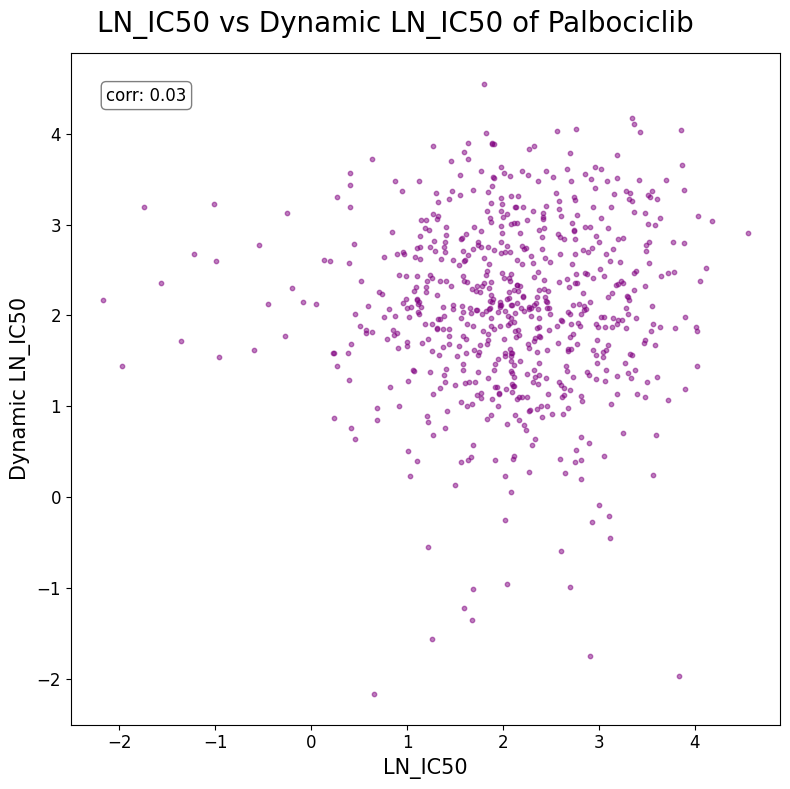

In [83]:
# plot new_label_data vs dynamic_label_data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(new_label_data, dynamic_label_data, alpha=0.5, s=10, color='purple')
corr, p_val = pearsonr(new_label_data, dynamic_label_data)
corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
ax.text(0.05, 0.95, f'corr: {corr_str}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# change the x and y axis labels size
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('LN_IC50', fontsize=15)
ax.set_ylabel('Dynamic LN_IC50', fontsize=15)
plt.suptitle(f'LN_IC50 vs Dynamic LN_IC50 of Palbociclib', fontsize=20)
plt.tight_layout()
plt.show()

In [84]:
new_label_data

SANGER_MODEL_ID
SIDM01132    2.082291
SIDM00848    2.114963
SIDM01111    2.966032
SIDM00909    2.809978
SIDM00807    1.240585
               ...   
SIDM00217    3.886044
SIDM00214    2.237966
SIDM00194    4.019477
SIDM00193    3.478666
SIDM00498    2.325066
Name: LN_IC50, Length: 665, dtype: float64

In [85]:
# join the two dataframes on the index

new_label_data = new_label_data.to_frame()
dynamic_label_data = dynamic_label_data.to_frame()

new_joint_data = new_label_data.join(dynamic_label_data, how='inner', lsuffix='_original', rsuffix='_dynamic')

new_joint_data

,LN_IC50_original,LN_IC50_dynamic
SIDM01132,2.082291,2.082291
SIDM00848,2.114963,2.114963
SIDM01111,2.966032,2.966032
SIDM00909,2.809978,2.809978
SIDM00807,1.240585,1.240585
...,...,...
SIDM00217,3.886044,3.886044
SIDM00214,2.237966,2.237966
SIDM00194,4.019477,4.019477
SIDM00193,3.478666,3.478666


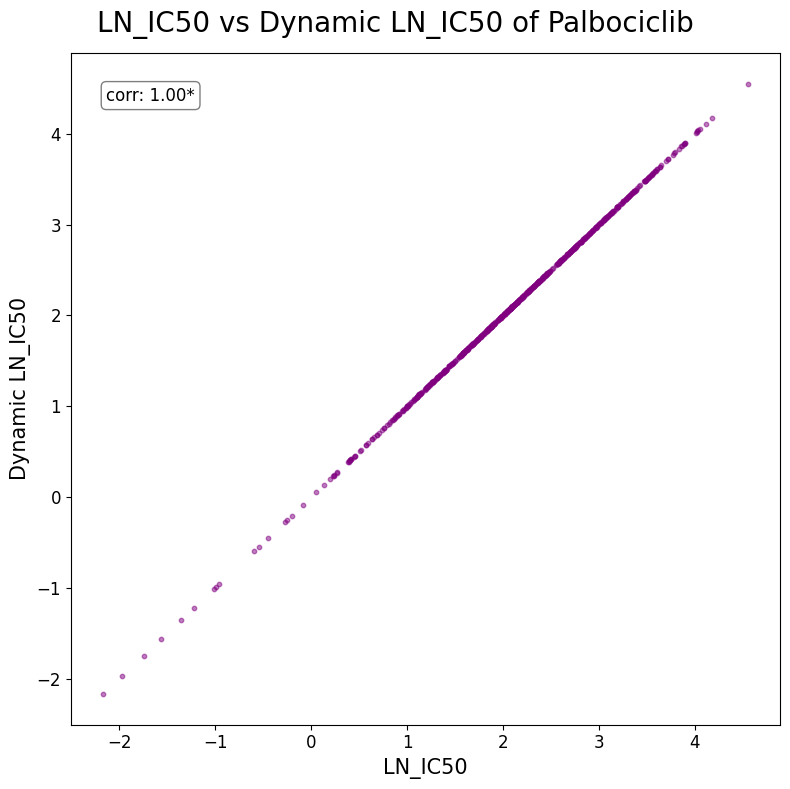

In [86]:
# plot new_label_data vs dynamic_label_data

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(new_joint_data['LN_IC50_dynamic'], new_joint_data['LN_IC50_original'], alpha=0.5, s=10, color='purple')
corr, p_val = pearsonr(new_joint_data['LN_IC50_dynamic'], new_joint_data['LN_IC50_original'])
corr_str = f'{corr:.2f}' if p_val > 0.05 else f'{corr:.2f}*'
ax.text(0.05, 0.95, f'corr: {corr_str}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
# change the x and y axis labels size
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('LN_IC50', fontsize=15)
ax.set_ylabel('Dynamic LN_IC50', fontsize=15)
plt.suptitle(f'LN_IC50 vs Dynamic LN_IC50 of Palbociclib', fontsize=20)
plt.tight_layout()
plt.show()